In [17]:
import tensorflow as tf
tf.enable_eager_execution()
import tensorflow_datasets as tfds
import keras
import sklearn.model_selection as sk
import pandas as pd
from tensorflow.keras.layers import *

In [2]:
#loading data from tensorflow datasets to get cifar data
#loaded data must be mapped to be readable
train_dataset = tfds.load("cifar10", with_info=False,split=tfds.Split.TRAIN)
train_dataset = train_dataset.map(lambda ele: tuple([ele['image'], ele['label']])).repeat().batch(16)

test_dataset = tfds.load("cifar10", with_info=False,split=tfds.Split.TEST)
test_dataset = test_dataset.map(lambda ele: tuple([ele['image'], ele['label']])).repeat().batch(16)


In [23]:
image, label = next(iter(train_dataset)) #dividing data into x_train and y_train
image_val, label_val = next(iter(test_dataset)) #dividing data into x_val and y_val

Training data shape (16, 32, 32, 3)


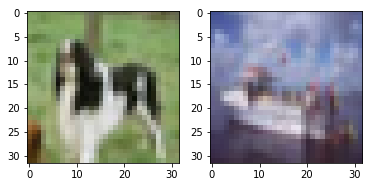

In [51]:
#printing data to make sure data load worked

from matplotlib import pyplot as plt
%matplotlib inline

print('Training data shape', image.shape)
_,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(image_val[10])
ax2.imshow(image_val[3])

In [ ]:
# airplane: 0
# automobile: 1
# bird: 2
# cat: 3
# deer: 4
# dog: 5
# frog: 6
# horse: 7
# ship: 8
# truck: 9

In [53]:

answer = model.predict(next(iter(test_dataset)))

import numpy as np
num_answer = np.argmax(answer[10])
#model's answer
num_answer

5

In [52]:
#actual answer in numpy
label_val[10]

<tf.Tensor: id=2420, shape=(), dtype=int64, numpy=5>

In [6]:
#modular inception block

def inception_block(x):
    x1 = Conv2D(filters=16,kernel_size=1,strides=2,padding='same',activation='relu')(x)
    x2 = Conv2D(filters=24,kernel_size=1,strides=2,padding='same',activation='relu')(x)
    x3 = Conv2D(filters=4,kernel_size=1,strides=2,padding='same',activation='relu')(x)
    x4 = MaxPooling2D(pool_size=3,strides=2,padding='same')(x)
    
    x2 = Conv2D(filters=32,kernel_size=3,strides=1,padding='same',activation='relu')(x2)
    x3 = Conv2D(filters=8,kernel_size=5,strides=1,padding='same',activation='relu')(x3)
    x4 = Conv2D(filters=8,kernel_size=1,strides=1,padding='same',activation='relu')(x4)
    #combining all convolutions as one layer
    con = concatenate([x1,x2,x3,x4])
    return con

In [7]:
#building model

#this is a smaller model than in the paper because cifar is a smaller dataset
inputs = Input(shape=(32,32,3))
x = Conv2D(filters=16,kernel_size=3,strides=2,padding='same',activation='relu')(inputs)
x = BatchNormalization()(x)

x = inception_block(x)

x = Conv2D(filters=32,kernel_size=3,strides=2,padding='same',activation='relu')(x)
x = BatchNormalization()(x)

x = inception_block(x)
x = inception_block(x)
x = inception_block(x)

x = Conv2D(filters=64,kernel_size=3,strides=2,padding='same',activation='relu')(x)
x = BatchNormalization()(x)

x = inception_block(x)

x = AveragePooling2D(pool_size=(3,3),strides=2,padding='same')(x)
x = SpatialDropout2D(rate=0.7)(x) #dropout helps prevent overfitting when you have a lot of parameters
x = Flatten()(x)
x = Dense(10, activation='relu')(x) #drops into 10 possible answers
x = Softmax()(x)

model = tf.keras.Model(inputs,x)

model.summary()

W0805 21:21:13.278178 140091101239040 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 24)     408         batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
opt = tf.train.AdamOptimizer(learning_rate=0.001)#defining learning rate

In [17]:
model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])#defining loss

In [7]:
model.fit(train_dataset,steps_per_epoch=50000,epochs=10,verbose=1,validation_data=test_dataset,validation_steps=10000)#start training, i loaded some previous weights so i didnt have to wait, but this is still works on its own

Epoch 1/10


W0805 15:13:31.160832 140374873450240 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


50000/50000 [==============================] - 1921s 38ms/step - loss: 1.3315 - acc: 0.5367 - val_loss: 1.1565 - val_acc: 0.6005
Epoch 2/10
50000/50000 [==============================] - 1931s 39ms/step - loss: 1.0094 - acc: 0.6585 - val_loss: 1.2219 - val_acc: 0.6156
Epoch 3/10
50000/50000 [==============================] - 1948s 39ms/step - loss: 0.8956 - acc: 0.6971 - val_loss: 1.2636 - val_acc: 0.6219
Epoch 4/10
50000/50000 [==============================] - 1927s 39ms/step - loss: 0.8253 - acc: 0.7213 - val_loss: 1.3621 - val_acc: 0.6045
Epoch 5/10
50000/50000 [==============================] - 1940s 39ms/step - loss: 0.7819 - acc: 0.7367 - val_loss: 1.3162 - val_acc: 0.6191
Epoch 6/10
50000/50000 [==============================] - 1903s 38ms/step - loss: 0.7481 - acc: 0.7482 - val_loss: 1.3436 - val_acc: 0.6176
Epoch 7/10
50000/50000 [==============================] - 1882s 38ms/step - loss: 0.7268 - acc: 0.7572 - val_loss: 1.3654 - val_acc: 0.6173
Epoch 8/10
50000/50000 [=======

In [8]:
model.save('inception-v1_1.0')

W0805 20:45:20.249067 140374873450240 hdf5_format.py:110] TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file. You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).


In [9]:
from tensorflow.keras.models import load_model

model = load_model('inception-v1_1.0')

W0806 19:09:43.443620 140438583117568 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0806 19:09:43.633462 140438583117568 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [28]:
opt = tf.train.AdamOptimizer(learning_rate=0.0001)
model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(train_dataset,steps_per_epoch=50000,epochs=10,verbose=1,validation_data=test_dataset,validation_steps=10000)

Epoch 1/10
50000/50000 [==============================] - 1293s 26ms/step - loss: 0.5294 - acc: 0.8246 - val_loss: 1.6462 - val_acc: 0.6247
Epoch 2/10
50000/50000 [==============================] - 1282s 26ms/step - loss: 0.4833 - acc: 0.8392 - val_loss: 1.7266 - val_acc: 0.6221
Epoch 3/10
50000/50000 [==============================] - 1275s 26ms/step - loss: 0.4633 - acc: 0.8463 - val_loss: 1.7675 - val_acc: 0.6189
Epoch 4/10
50000/50000 [==============================] - 1293s 26ms/step - loss: 0.4509 - acc: 0.8497 - val_loss: 1.8291 - val_acc: 0.6198
Epoch 5/10
50000/50000 [==============================] - 1314s 26ms/step - loss: 0.4409 - acc: 0.8533 - val_loss: 1.8414 - val_acc: 0.6187
Epoch 6/10
50000/50000 [==============================] - 1307s 26ms/step - loss: 0.4345 - acc: 0.8556 - val_loss: 1.8935 - val_acc: 0.6144
Epoch 7/10
50000/50000 [==============================] - 1318s 26ms/step - loss: 0.4252 - acc: 0.8589 - val_loss: 1.9369 - val_acc: 0.6134
Epoch 8/10
50000/500

In [10]:
from keras.datasets import cifar10

(x_train,y_train),(x_val,y_val) = cifar10.load_data()

Training data shape (50000, 32, 32, 3)


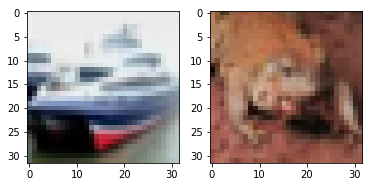

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline

print('Training data shape', x_train.shape)
_,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(x_val[1].reshape(32,32,3))
ax2.imshow(x_val[5].reshape(32,32,3))

In [23]:
answer = model.predict(x_val[5].reshape(1,32,32,3))

In [24]:
import numpy as np
num_answer = np.argmax(answer[0])

In [25]:
y_val[5]

array([6])

In [26]:
num_answer

6